In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
import seaborn as sns
sns.set(style="white")
%matplotlib inline 
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Load the data from the files and name them A and B

A = Table.read('/home/juancho/Master/Semester3/DBDM/DDM2017_FinalProject/FinalProject/Q2/Tables/PhotoZFileA.vot').to_pandas()
B = Table.read('/home/juancho/Master/Semester3/DBDM/DDM2017_FinalProject/FinalProject/Q2/Tables/PhotoZFileB.vot').to_pandas()

In [3]:
# From the colours and mag_r I calculate the magnitudes of all the filters

# First for table A (and also stack the data in MA)

A['i']  = A['mag_r'].values - A["r-i"].values
A['z']  = A['i'].values - A["i-z"].values
A['g']  = A['mag_r'].values + A["g-r"].values
A['u']  = A['g'].values + A["u-g"].values
MA      = np.vstack((A['mag_r'].values, A['i'].values, A['z'].values, A['g'].values, A['u'].values)).T
Zspec_A = A['z_spec'].values

# Now for B (and also stack the data in MB)

B['i']  = B['mag_r'].values - B["r-i"].values
B['z']  = B['i'].values - B["i-z"].values
B['g']  = B['mag_r'].values + B["g-r"].values
B['u']  = B['g'].values + B["u-g"].values
MB      = np.vstack((B['mag_r'].values,B['i'].values,B['z'].values, B['g'].values,B['u'].values)).T
zspec_B = B['z_spec'].values

Training error is:

 Etheta = 0.0107609493248

Generalization Error:

 Etheta = 0.0133751684158



<function matplotlib.pyplot.show>

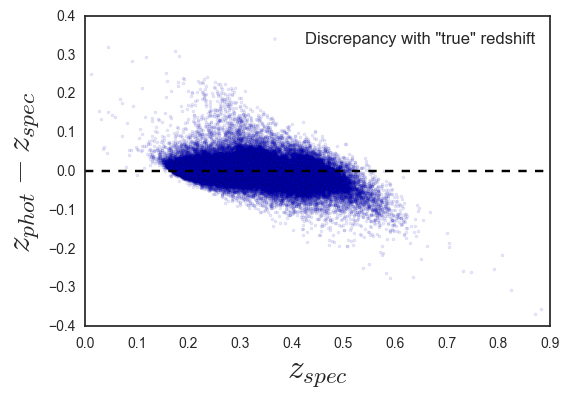

In [4]:
# Define the k-nearest neighbours method specifying the number of neighbours and letting the metric as the
# default one (Minkowski)

neigh = KNeighborsRegressor(n_neighbors=5, leaf_size=30,  weights='uniform', p=2, metric_params=None, n_jobs=1)
func = neigh.fit(MA, Zspec_A) 

# Calculate the training error using this method

Zpred_A = func.predict(MA)
Error = np.median( np.abs( (Zspec_A - Zpred_A)/(1.0 + Zspec_A) ) )
print("Training error is:\n\n Etheta = {}\n".format(Error))

# Calculate the generalization error using this method

Zpred_B = func.predict(MB)
Gen_err = np.median(np.abs((zspec_B - Zpred_B)/(1 + zspec_B)))
print("Generalization Error:\n\n Etheta = {}\n".format(Gen_err))

# Plot the discrepancy between the modeled redshifts and the real redshifts

plt.scatter(Zspec_A,Zpred_A-Zspec_A, marker='.', alpha=0.1, label='Discrepancy with "true" redshift')
plt.xlabel(r'$z_{spec}$', size=24)
plt.ylabel(r'$z_{phot}-z_{spec}$', size=24)
plt.ylim(-0.4,0.4)
plt.xlim(0.0,0.9)
plt.axhline(y=0.0, linestyle= '--', color='black')
plt.legend(prop={'size': 12})
plt.show

In [5]:
# Here I define the median on the data to clearly see how simetric the relative residuals are with respect to 0

residuals_knn = Zpred_A-Zspec_A
relative_residuals = residuals_knn/Zspec_A

def running_median(x, y, N=None, binsize=None):

    if binsize is not None:
        bins = np.arange(x.min(), x.max(), binsize)
        N = len(bins)
    else:
        bins = np.linspace(x.min(), x.max(), N)
        binsize = bins[1]-bins[0]
        
    # To get the bins and their positions.
    idx  = np.digitize(x, bins)
    
    r_med = [np.median(y[idx==k]) for k in range(N)]
    x_bins = [np.mean(x[idx==k]) for k in range(N)]
    
    return np.array(x_bins), np.array(r_med), bins

Zspec_knn, med_knn, bins = running_median(Zspec_A, relative_residuals, N = 5, binsize = 0.15)

/home/juancho/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/juancho/.local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


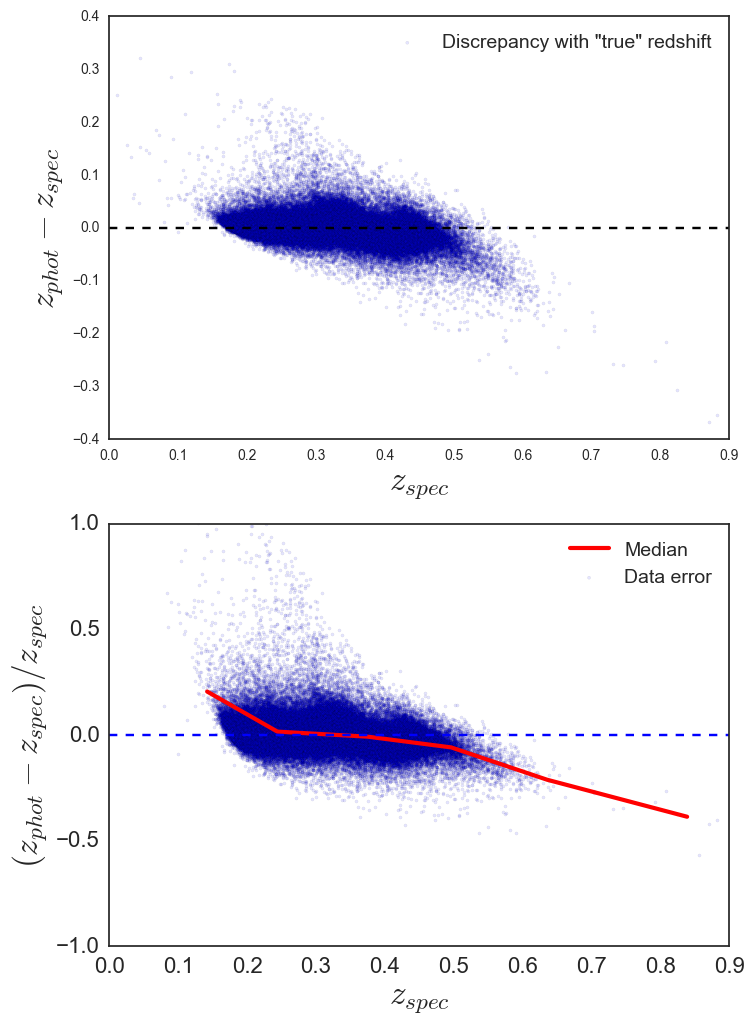

In [15]:
# And make a single plot to include in the report with the useful information

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8, 12))

ax[0].scatter(Zspec_A,Zpred_A-Zspec_A, marker='.', alpha=0.1, label='Discrepancy with "true" redshift')
ax[0].set_xlabel(r'$z_{spec}$', size=24)
ax[0].set_ylabel(r'$z_{phot}-z_{spec}$', size=24)
ax[0].set_ylim(-0.4,0.4)
ax[0].set_xlim(0.0,0.9)
ax[0].axhline(y=0.0, linestyle= '--', color='black')
ax[0].legend(prop={'size': 14})

ax[1].scatter(Zspec_A, relative_residuals, marker='.', alpha=0.1, label="Data error")
ax[1].plot(Zspec_knn, med_knn, lw=3, color='red', label="Median")

ax[1].set_xlabel(r'$z_{spec}$', size=24)
ax[1].set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=24, fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].set_ylim(-1.0,1)
ax[1].set_xlim(0.0,0.9)
ax[1].axhline(y=0.0, linestyle= '--')
ax[1].legend(prop={'size': 14})
plt.savefig('2_d.png')